In [1]:
# Load Dataset

import torch
#dataset = torch.load("../torchfem_dataset/simple_beam_reduced/combined.pt",weights_only=False)
dataset = torch.load("../torchfem_dataset/simple_beam_reduced/combined_50.pt",weights_only=False)
#dataset_2 = torch.load("../torchfem_dataset/tube_2/tube_combined.pt",weights_only=False)

In [2]:
## Process dataset for training - Nodes only
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData

def build_laststep_features(data, dtype=torch.float32):
    ## Collapse to peak load timestep
    #print(data.keys)
    len = data['nodes'].f_ext.shape[0]
    t = int(len/2-1)
    # Nodes: x = [pos, bc, f_ext[-1], f_int[-1]]  (no leakage of u_ts into x)
    #pos   = data['nodes'].pos.to(dtype) #no need to include
    bc    = data['nodes'].bc.to(dtype)
    f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].fext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].x = torch.cat([bc, f_ext], dim=-1)


    # Target: nodes â†’ u_ts[-1] (3D)
    data['nodes'].y_u = data['nodes'].u_ts[t].to(dtype)
    data['nodes'].y_fint = data['nodes'].f_ts[t].to(dtype)

    # (Optional) free large tensors you won't use further to save RAM/VRAM
    del data['nodes'].bc, data['nodes'].u_ts, data['nodes'].f_ext, data['nodes'].f_int, data['elements'].material#, data['nodes'].pos
    del data['elements'].s_ts, data['elements'].d_ts, data['elements'].material, data['nodes'].f_ts, data['elements'].s_ts, data['elements']
    del data[('nodes','belongs_to','elements')], data[('elements','contributes','nodes')]

    #print(data.keys)

    return data

class HeteroStandardScaler:
    def __init__(self):
        self.node_stats = {}
        self.edge_stats = {}

    def fit(self, dataset):
        node_x = torch.cat([d['nodes'].x[:,3:].float() for d in dataset],dim=0)
        node_f = torch.cat([d['nodes'].y_fint.float() for d in dataset],dim=0)
        node_u = torch.cat([d['nodes'].y_u.float() for d in dataset],dim=0)
        edge_acc = {}
        # compute mean/std
        for data in dataset:

            for etype in data.edge_types:
                if "edge_attr" in data[etype]:
                    edge_acc.setdefault(etype, []).append(data[etype].edge_attr.float())
        
        self.node_stats['nodes_x'] = {
            "mean": node_x.mean(dim=0, keepdim=True),
            "std":  node_x.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_f'] = {
            "mean": node_f.mean(dim=0, keepdim=True),
            "std":  node_f.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_u'] = {
            "mean": node_u.mean(dim=0, keepdim=True),
            "std":  node_u.std(dim=0, keepdim=True) + 1e-8}

        for etype, mats in edge_acc.items():
            E = torch.cat(mats, dim=0)
            self.edge_stats[etype] = {
                "mean": E.mean(dim=0, keepdim=True),
                "std":  E.std(dim=0, keepdim=True) + 1e-8}


    def transform(self, data: HeteroData):
        # apply normalization
        x = data['nodes'].x[:,3:].float()
        m_x = self.node_stats['nodes_x']["mean"]
        s_x = self.node_stats['nodes_x']["std"]
        data['nodes'].x[:,3:] = (x - m_x) / s_x
        y_f = data['nodes'].y_fint.float()
        m_f = self.node_stats['nodes_f']["mean"]
        s_f = self.node_stats['nodes_f']["std"]
        data['nodes'].y_fint = (y_f - m_f) / s_f
        y_u = data['nodes'].y_u.float()
        m_u = self.node_stats['nodes_u']["mean"]
        s_u = self.node_stats['nodes_u']["std"]
        data['nodes'].y_u = (y_u - m_u) / s_u

        # edges
        for etype in data.edge_types:
            if etype in self.edge_stats and "edge_attr" in data[etype]:
                e = data[etype].edge_attr.float()
                m = self.edge_stats[etype]["mean"]
                s = self.edge_stats[etype]["std"]
                data[etype].edge_attr = (e - m) / s

        return data
    
    def inverse_transform(self, data: HeteroData):
        # Nodes
        m, s = self.node_stats["nodes_u"]["mean"], self.node_stats["nodes_u"]["std"]
        data = data * s + m

        return data

scaler = HeteroStandardScaler()

## DataLoader with train/val split
dataset_p = [build_laststep_features(d) for d in dataset]
scaler.fit(dataset_p)
dataset_t = [scaler.transform(d) for d in dataset_p]

def split_dataset(dataset, val_ratio=0.1, shuffle=True):
    n = len(dataset)
    idx = torch.randperm(n) if shuffle else torch.arange(n)
    n_val = max(1, int(n * val_ratio))
    val_idx = idx[:n_val].tolist()
    train_idx = idx[n_val:].tolist()
    train_set = [dataset[i] for i in train_idx]
    val_set   = [dataset[i] for i in val_idx]
    return train_set, val_set

# preprocess first
train_set, val_set = split_dataset(dataset_t, val_ratio=0.1)


In [3]:
train_set, val_set = split_dataset(dataset_t, val_ratio=0.1)
print(train_set[10])

HeteroData(
  nodes={
    pos=[5216, 3],
    fext=[5216, 3],
    x=[5216, 6],
    y_u=[5216, 3],
    y_fint=[5216, 3],
  },
  (nodes, adjacent, nodes)={
    edge_index=[2, 23053],
    edge_attr=[23053, 3],
  },
  (nodes, adjacent_rev, nodes)={
    edge_index=[2, 23053],
    edge_attr=[23053, 3],
  }
)


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import ModuleList

from torch_geometric.nn import pool
import torch_geometric.transforms as T
from torch_geometric.nn import MLP, GENConv, to_hetero

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

class GNN(torch.nn.Module):
    def __init__(self, in_channels,edge_in,layers,latent_dim, out_channels):
        super().__init__()
        #self.proj = nn.Linear(in_channels, latent_dim)
        #self.edge_proj = nn.Linear(edge_in, latent_dim)

        self.proj = MLP(in_channels=in_channels,hidden_channels=latent_dim,out_channels=latent_dim,num_layers=2,act='relu',norm='layer')
        self.edge_proj = MLP(in_channels=edge_in,hidden_channels=latent_dim,out_channels=latent_dim,num_layers=2,act='relu',norm='layer')
        self.layers = layers

        self.encoding_layers = ModuleList([
            GENConv(latent_dim * 2, latent_dim, norm='layer')
            for _ in range(layers)])
        self.dropout = torch.nn.Dropout(p=0.1)

        #self.conv1 = GENConv(latent_dim,latent_dim,edge_dim=latent_dim) #num_layers=layers
        self.conv2 = GENConv(latent_dim,out_channels,edge_dim=latent_dim) #num_layers=layers

    

    def forward(self,x,edge_index,edge_attr, batch):
        #x = torch.relu(self.proj(x))
        #edge_attr = torch.relu(self.edge_proj(edge_attr))
        x = self.proj(x)
        edge_attr = self.edge_proj(edge_attr)
        
        for conv in self.encoding_layers:
            x_global = pool.global_mean_pool(x,batch)
            x_expanded = x_global[batch]
            m = conv(torch.cat([x, x_expanded], dim=1), edge_index, edge_attr=edge_attr)
            m = self.msg_norm(m, batch)          # normalize messages
            x = x + m                            # residual
            x = self.dropout(x)
        #for _ in range(self.layers):
        #    x = torch.relu(self.conv1(x,edge_index,edge_attr))
        x = self.conv2(x, edge_index, edge_attr)
        return x
    
##TODO: 
# deeper model - test message passing steps vs. error
# mean pooling - in encoding step: see GABI repo; magedgepooling

##later:
# element stresses simple MLP
# force-based calcs & sequential input


model = GNN(in_channels=6,edge_in=3,layers=12,latent_dim=32,out_channels=3).to(device)
#model = to_hetero(model,dataset_t[0].metadata(),aggr='sum')

In [ ]:
import pandas as pd

opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

## Losses
#ALPHA_FINT = 0.3   # node f_int aux
#LAMBDA_EQ  = 0.0   # equilibrium regularizer on nodes

def compute_losses(batch, pred):
    # Nodes
    y_u    = batch['nodes'].y_u
    #y_fint = batch['nodes'].y_fint
    #fext   = batch['nodes'].x[:,3:6]
    #bc = batch['nodes'].x[:,:3]
    #pu  = pred['u'] 

    #print(pred)
    
    #pf = pred['fint']

    L_u    = F.mse_loss(pred, y_u)
    #L_fint = F.mse_loss(pf, y_fint)
    #L_eq   = F.mse_loss(((torch.ones_like(bc)-bc)*(pf - fext)).sum(),torch.zeros((),device=bc.device))


    loss = L_u #+ ALPHA_FINT * L_fint + LAMBDA_EQ * L_eq
    return loss, {'L_u': L_u.item()}#, 'L_fint': L_fint.item(), 'L_eq': L_eq.item(),
                  

## Training Loop

def run_epoch(loader, train=True):
    model.train(train)
    total, last_loss_dict = 0.0, {}
    for batch in loader:
        batch = batch.to(device)
        opt.zero_grad(set_to_none=True)
        #print(batch)

        node_data = batch['nodes']
        edge_data = batch['nodes', 'adjacent', 'nodes']

        pred = model(
            node_data.x,
            edge_data.edge_index,
            edge_data.edge_attr,
            node_data.batch,      # <— pass the assignment vector
        )
        
        loss, loss_dict = compute_losses(batch, pred)
        last_loss_dict = loss_dict  # keep something to return

        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        total += loss.item()

    steps = max(1, len(loader))
    return total / steps, last_loss_dict


EPOCHS = 100
best_val = float("inf")
best_state = None
loss_records = []

torch.cuda.empty_cache()
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)  # adjust batch_size to your memory
val_loader   = DataLoader(val_set,   batch_size=1, shuffle=False)

for epoch in range(1, EPOCHS + 1):
    train_loss, train_ld = run_epoch(train_loader, train=True)
    model.eval()
    with torch.no_grad():
        val_loss, val_ld = run_epoch(val_loader, train=False)

    scheduler.step(val_loss)
    loss_records.append({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f}")

if best_state is not None:
    model.load_state_dict(best_state)
torch.save(model.state_dict(), "1204_weights.pt")
print("Best val:", best_val)

pd.DataFrame(loss_records).to_csv("1204_losses.csv", index=False)


Epoch 001 | train 2.216705 | val 0.197970
Epoch 005 | train 1.264084 | val 0.030392
Epoch 010 | train 1.540868 | val 0.007455
Epoch 015 | train 0.895426 | val 0.102419
Epoch 020 | train 1.090651 | val 0.004756
Epoch 025 | train 1.105215 | val 0.026881
Epoch 030 | train 0.859421 | val 0.005034
Epoch 035 | train 1.295452 | val 0.256822
Epoch 040 | train 1.784699 | val 0.027874
Epoch 045 | train 0.935043 | val 0.002188
Epoch 050 | train 1.350483 | val 0.001797
Epoch 055 | train 1.049266 | val 0.001241
Epoch 060 | train 1.601740 | val 0.002539
Epoch 065 | train 0.869151 | val 0.001603
Epoch 070 | train 0.917060 | val 0.001607
Epoch 075 | train 1.002450 | val 0.001751
Epoch 080 | train 1.055612 | val 0.001576


In [6]:
from copy import deepcopy
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
out_samples = []
with torch.no_grad():
    for data in train_loader:
        d = deepcopy(data)         # keep originals intact
        d = d.to(device)
        x = d['nodes'].x
        edge_index = d[("nodes", "adjacent", "nodes")].edge_index
        edge_attr = d[("nodes", "adjacent", "nodes")].edge_attr
        #edge_index = data.edge_index_dict.values()
        #edge_attr = data.edge_attr_dict.values()
        batch = d['nodes'].batch

        pred = model(x, edge_index,edge_attr,batch).cpu()

        pred = scaler.inverse_transform(pred)

        # Detach and move predictions to CPU for saving
        pu = pred.detach().cpu()

        # Move the data structure back to CPU before attaching CPU tensors
        d = d.to('cpu')

        # Attach predictions into the dictionary
        d['nodes'].pred_u = pu

        out_samples.append(d)

# Save to a new file
save_path = "../base/test_dataset/preds_1204.pt"
torch.save(out_samples, save_path)
print(f"Saved {len(out_samples)} samples with predictions to {save_path}")

Saved 50 samples with predictions to ../base/test_dataset/preds_1204.pt


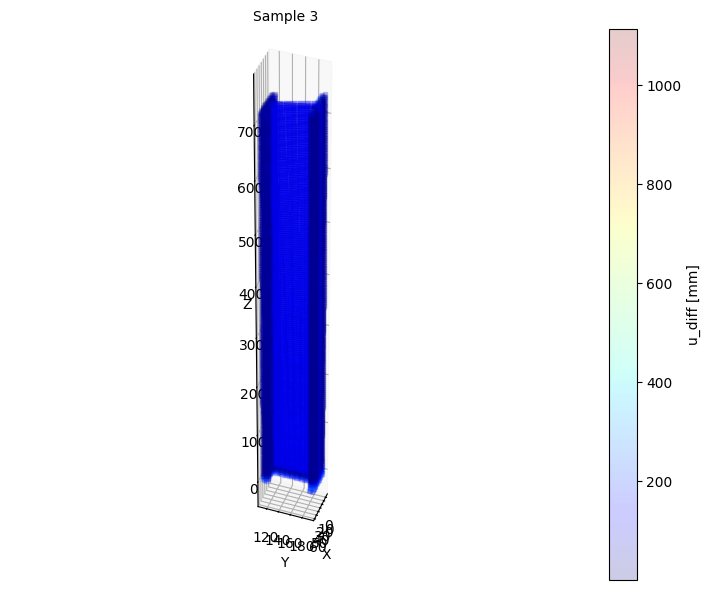

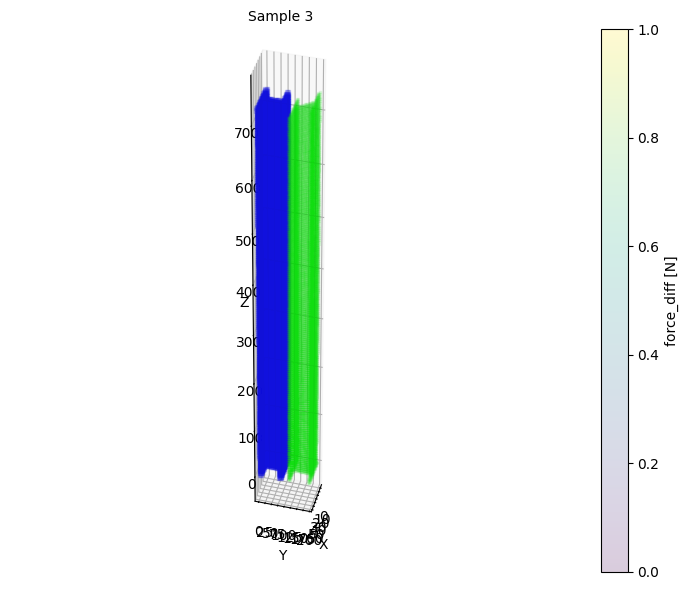

In [7]:
## Visualization - Matplotlib 3D Scatter Plot
import matplotlib.pyplot as plt
import numpy as np
import torch

out_samples = torch.load("../base/test_dataset/preds_1204.pt",weights_only=False)
sample = 3

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.title(f'Sample {sample}',fontsize=10)

#sc = ax.scatter(out_samples[sample]['nodes']['pos'],'k',alpha=0.3,label='initial position')
#ax[i,1].plot(out_samples[sample]['nodes']['pred_u'][:],alpha=0.3,label='predicted')

#ax.plot_trisurf(V[:,0],V[:,1],V[:,2],triangles=F,edgecolor='#888888',linewidth=lw,antialiased=True,color='#dddddd',alpha=0.1)

vis_scale = 1000

pos_init = out_samples[sample]['nodes']['pos']
pos_true = pos_init+out_samples[sample]['nodes']['y_u']*vis_scale
pos_pred = pos_init+out_samples[sample]['nodes']['pred_u']*vis_scale
pos_diff = np.linalg.norm(pos_true-pos_pred,axis=-1)/vis_scale

#force_true = out_samples[sample]['nodes']['y_fint']
#force_pred = out_samples[sample]['nodes']['pred_fint']
#force_diff = np.linalg.norm(force_true-force_pred,axis=-1)

#sc = ax.scatter(pos_init[:,0],pos_init[:,1],pos_init[:,2],s=2,marker='s',c='#1111dd',alpha=0.2,depthshade=True)
#sc2 = ax.scatter(pos_true[:,0],pos_true[:,1],pos_true[:,2],s=2,marker='s',c='#11dd11',alpha=0.1,depthshade=True)
#sc3 = ax.scatter(pos_pred[:,0],pos_pred[:,1],pos_pred[:,2],s=2,marker='s',c='#dd1111',alpha=0.2,depthshade=True)
sc = ax.scatter(pos_true[:,0],pos_true[:,1],pos_true[:,2],s=10,marker='s',c=pos_diff,cmap='jet',alpha=0.2,depthshade=True)
plt.colorbar(sc, ax=ax, label='u_diff [mm]')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=40, azim=20)
ranges = np.ptp(out_samples[sample]['nodes']['pos'].T, axis=1)
ax.set_box_aspect(ranges)

plt.tight_layout()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.title(f'Sample {sample}',fontsize=10)

sc = ax.scatter(pos_init[:,0],pos_init[:,1],pos_init[:,2],s=10,marker='s',c='#1111dd',alpha=0.2,depthshade=True)
plt.colorbar(sc, ax=ax, label='force_diff [N]')
sc2 = ax.scatter(pos_true[:,0],pos_true[:,1],pos_true[:,2],s=2,marker='s',c='#11dd11',alpha=0.1,depthshade=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=40, azim=15)
ranges = np.ptp(out_samples[sample]['nodes']['pos'].T, axis=1)
ax.set_box_aspect(ranges)

plt.tight_layout()

In [77]:
from collections import Counter
import pyvista as pv
from collections import defaultdict
import numpy as np

vis_scale = 1000

pos = out_samples[sample]['nodes']['pos'].cpu().numpy()        # (N,3)
edges = out_samples[sample][('nodes','adjacent','nodes')]['edge_index'].T.cpu().numpy()
pos_true = pos+(out_samples[sample]['nodes']['y_u']*vis_scale).cpu().numpy()
pos_pred = pos+(out_samples[sample]['nodes']['pred_u']*vis_scale).cpu().numpy()

adj = defaultdict(set)
for i, j in edges:
    adj[i].add(j)
    adj[j].add(i)

def find_quad_faces(adj):
    faces = set()

    for a in adj:
        for b in adj[a]:
            for c in adj[b]:
                if c == a: continue
                for d in adj[c]:
                    if d in adj[a] and d not in (a,b,c):    # closes the loop
                        quad = tuple(sorted([a,b,c,d]))
                        faces.add(quad)

    return np.array(list(faces))

faces = find_quad_faces(adj)

# Count duplicates
face_counts = Counter([tuple(sorted(f)) for f in faces])

surface_faces = np.array([f for f, c in face_counts.items() if c == 1])


# Convert to VTK-style quad faces
faces_pv = np.hstack([
    np.concatenate([[4], face]) for face in surface_faces
])

#mesh = pv.PolyData(pos_pred, faces_pv)
mesh = pv.PolyData(pos_true, faces_pv)

mesh.plot(
    show_edges=False,
    color="#8fa7ff",
    smooth_shading=False,
    opacity=0.95,
)


Widget(value='<iframe src="http://localhost:52395/index.html?ui=P_0x1b60d263b90_18&reconnect=auto" class="pyvi…

tensor(-2613.0991)


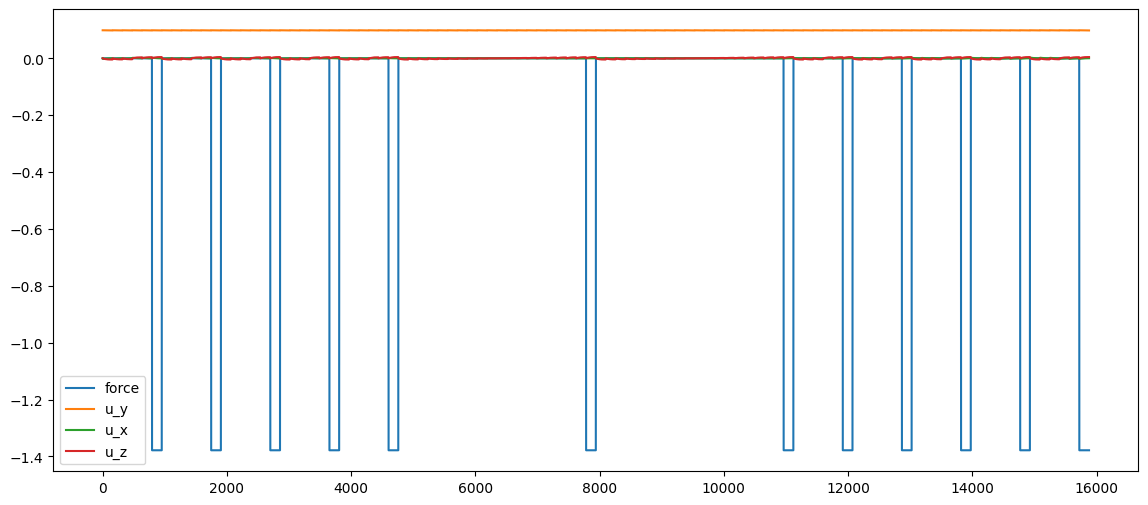

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(out_samples[sample]['nodes']['fext'][:,1],label='force')
plt.plot(out_samples[sample]['nodes']['y_u'][:,1],label='u_y')
plt.plot(out_samples[sample]['nodes']['y_u'][:,0],label='u_x')
plt.plot(out_samples[sample]['nodes']['y_u'][:,2],label='u_z')
plt.legend()
#plt.xlim(0,2000)
print(out_samples[sample]['nodes']['fext'].sum())